# APL 745 (Assignment - 3 --- Optimization)

In [3]:
## Import all the required libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import random_split,DataLoader,Subset
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor,Normalize
import warnings
warnings.filterwarnings("ignore")

## Data Gathering and preprocessing

In [5]:
# Define one-hot encoding function
def one_hot_encoding(labels, num_classes=10):
    encoded_labels = np.zeros((len(labels), num_classes))
    for i in range(len(labels)):
        encoded_labels[i][labels[i]] = 1
    return encoded_labels


# Load MNIST dataset
mnist_dataset = datasets.MNIST(
    root='./data',
    train=True, 
    download=True,
    transform=ToTensor
)

# Total number of samples
total_samples = len(mnist_dataset)

indices = list(range(total_samples))

# Create training, validation, and testing samples of the required size
train_indices = indices[:5000]
val_indices = indices[5000:6000]
test_indices = indices[6000:8000]

train_dataset = Subset(mnist_dataset, train_indices)
val_dataset = Subset(mnist_dataset, val_indices)
test_dataset = Subset(mnist_dataset, test_indices)

# One-hot encode the labels and convert them to PyTorch tensors
train_labels = torch.tensor(one_hot_encoding([mnist_dataset.targets[i] for i in train_indices]))
val_labels = torch.tensor(one_hot_encoding([mnist_dataset.targets[i] for i in val_indices]))
test_labels = torch.tensor(one_hot_encoding([mnist_dataset.targets[i] for i in test_indices]))

# Modify train_dataset, val_dataset, and test_dataset to include one-hot encoded labels
for i, idx in enumerate(train_indices):
    train_dataset.dataset.targets[idx] = train_labels[i].argmax().item()

for i, idx in enumerate(val_indices):
    val_dataset.dataset.targets[idx] = val_labels[i].argmax().item()

for i, idx in enumerate(test_indices):
    test_dataset.dataset.targets[idx] = test_labels[i].argmax().item()

# Batch size
batch_size = 1

# Finally, load the datasets using DataLoader with a batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Finally, load the datasets using DataLoader
train_dataloader_1 = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
val_dataloader_1 = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_dataloader_1 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Implementing the Network 

In [3]:
class Artificial_NN(nn.Module):
    
    def __init__(self):
        super(Artificial_NN, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden_layers = nn.Sequential(
            nn.Linear(784,200),
            nn.ReLU(),
            nn.Linear(200,200),
            nn.ReLU(),
            nn.Linear(200,10)  
        )
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, input_d):
        input_outcome = self.flatten(input_d)
        hidden_outcome = self.hidden_layers(input_outcome)
        final_predictions = self.softmax(hidden_outcome)
        return final_predictions

## Function for calculating the accuracy

In [4]:
def calculate_accuracy(model, dataloader):    
    accuracy = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            accuracy = correct / total
    return accuracy

## Implementing Stochastic gradient descent (SGD)

In [5]:
class SGD:
    def __init__(self, parameters, lr=0.01):
        self.parameters = list(parameters)  # Convert parameters to list
        self.lr = lr

    def step(self):
        for param in self.parameters:
            if param.grad is not None:
                # Update parameter using gradient and learning rate
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                # Clear gradient for parameter
                param.grad.zero_()
                

## Implementing momentum optimizer

In [28]:
class Momentum_optimizer:
    
    def __init__(self, parameters, lr=0.01, damping_pr=0.9):
        self.parameters = list(parameters)
        self.lr = lr
        self.damping_pr = damping_pr
        self.history = [torch.zeros_like(param.data) for param in self.parameters]

    def step(self):
        for param, history in zip(self.parameters, self.history):
            if param.grad is not None:
                history.data = (self.damping_pr * history.data) + (self.lr * param.grad)
                param.data -= history.data

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()
    

## Implementing Nestorov accelerated gradient (NAG)

In [7]:
class NAG:
    def __init__(self, parameters,lr=0.01, damping_pr=0.9):
        self.parameters = list(parameters)
        self.lr = lr
        self.damping_pr = damping_pr
        self.history = [torch.zeros_like(param.data) for param in self.parameters]

    def step(self):
        
        for param, history in zip(self.parameters,self.history):
            # Update lookahead parameter
            look_aheads = param.data - (self.damping_pr * history.data)
            temp = param.data
            param.data = look_aheads
            if param.grad is not None:
                history.data = (self.damping_pr * history.data) + (self.lr * param.grad)
            param.data = temp
            param.data = param.data - history.data
                  
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

## Implementing Adaptive Gradient (AdaGrad)

In [8]:
class AdaGrad:
    def __init__(self, parameters,lr=0.01):
        self.parameters = list(parameters)
        self.lr = lr
        self.history = [torch.zeros_like(param.data) for param in self.parameters]

    def step(self):
        
        for param, history in zip(self.parameters,self.history):
            
            if param.grad is not None:
                gradients = param.grad
                
            history.data = history.data + torch.square(gradients)
                
            epsilon = 1e-8
            updated_param_data = param.data - ((self.lr * gradients) / torch.sqrt(history.data + epsilon))
            param.data.copy_(updated_param_data)
                  
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

## Implementing Root Mean Square propagation (RMSProp)

In [21]:
class RMSProp:
    def __init__(self, parameters,lr=0.01, coefficient_pr = 0.9):
        self.parameters = list(parameters)
        self.lr = lr
        self.coefficient_pr = coefficient_pr
        self.history = [torch.zeros_like(param.data) for param in self.parameters]

    def step(self):     
        for param, history in zip(self.parameters,self.history):
            
            if param.grad is not None:
                gradients = param.grad
                
            history.data = (self.coefficient_pr*history.data) + (1-self.coefficient_pr)*torch.square(gradients)
                
            epsilon = 1e-8
            updated_param_data = param.data - ((self.lr * gradients) / torch.sqrt(history.data + epsilon))
            param.data.copy_(updated_param_data)
                  
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

## Implementing Adaptive moment estimation (ADAM)

In [14]:
class ADAM:
    def __init__(self, parameters,lr=0.01, coefficient_pr = 0.999 , damping_pr = 0.9):
        self.parameters = list(parameters)
        self.lr = lr
        self.damping_pr = damping_pr
        self.coefficient_pr = coefficient_pr
        self.history = [torch.zeros_like(param.data) for param in self.parameters]
        self.momentum = [torch.zeros_like(param.data) for param in self.parameters]

    def step(self):     
        for param,momentum,history in zip(self.parameters,self.momentum,self.history):
            
            if param.grad is not None:
                gradients = param.grad
                
            momentum.data = (self.damping_pr*momentum.data) + (1-self.damping_pr)*gradients
            history.data = (self.coefficient_pr*history.data) + (1-self.coefficient_pr)*torch.square(gradients)
                
            epsilon = 1e-8
            updated_param_data = param.data - ((self.lr * momentum.data) / torch.sqrt(history.data + epsilon))
            param.data.copy_(updated_param_data)
                  
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

## Implementing ADAM with bias correction

In [15]:
class ADAM_with_bias_correction:
    def __init__(self, parameters,lr=0.01, coefficient_pr = 0.999 , damping_pr = 0.9):
        self.parameters = list(parameters)
        self.lr = lr
        self.damping_pr = damping_pr
        self.coefficient_pr = coefficient_pr
        self.history = [torch.zeros_like(param.data) for param in self.parameters]
        self.momentum = [torch.zeros_like(param.data) for param in self.parameters]

    def step(self):     
        for param,momentum,history in zip(self.parameters,self.momentum,self.history):
            
            if param.grad is not None:
                gradients = param.grad
                
            momentum.data = (self.damping_pr*momentum.data) + (1-self.damping_pr)*gradients
            momentum_hat = momentum.data/(1-self.damping_pr)
            history.data = (self.coefficient_pr*history.data) + (1-self.coefficient_pr)*torch.square(gradients)
            history_hat = history.data/(1-self.coefficient_pr)
                
            epsilon = 1e-8
            updated_param_data = param.data - ((self.lr * momentum_hat) / torch.sqrt(history_hat + epsilon))
            param.data.copy_(updated_param_data)
                  
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

## Network training with various optimizers

In [29]:
def Train_Network(num_of_epochs,learning_rate,train_dataloader,val_dataloader,full_train_dataloader,full_val_dataloader,choose_optimizer):
    
    # Instanciate your model
    ANN = Artificial_NN() 
    
    ANN_adam = Artificial_NN()
    
    # choosing the cross-entropy loss
    loss_fn = nn.CrossEntropyLoss()
    
    
    # Choose the optimizer 
    if(choose_optimizer == 0):
        optimizer = SGD(ANN.parameters(), lr = learning_rate)
    elif(choose_optimizer == 1):
        optimizer = Momentum_optimizer(ANN.parameters(),lr = learning_rate)
    elif(choose_optimizer == 2):
        optimizer = NAG(ANN.parameters(),lr = learning_rate)
    elif(choose_optimizer == 3):
        optimizer = AdaGrad(ANN.parameters(),lr = learning_rate)
    elif(choose_optimizer == 4):
        optimizer = RMSProp(ANN.parameters(),lr = learning_rate ,coefficient_pr = 0.9)
    elif(choose_optimizer == 5):
        optimizer = ADAM(ANN.parameters(),lr = learning_rate ,coefficient_pr = 0.999,damping_pr = 0.9)
    elif(choose_optimizer == 6):
        optimizer = ADAM_with_bias_correction(ANN.parameters(),lr = learning_rate ,coefficient_pr = 0.999,damping_pr = 0.9)
        
    
    optimizer_adam = optim.Adam(ANN_adam.parameters(), lr=learning_rate)
    
    train_losses = []  # List to store training losses for plotting
    val_losses = []    # List to store validation losses for plotting
    train_accuracies = []  # List to store training accuracies for plotting
    val_accuracies = []    # List to store validation accuracies for plotting
    train_accuracies_Adam = []
    val_accuracies_Adam = []
    
    ## Epoch loop for calculating accuracy with pytorch ADAM optimizer
    
    for epoch in range(num_of_epochs):
        
        ANN_adam.train()
        
        for idx,(inputs,labels) in enumerate (full_train_dataloader):
            
            optimizer_adam.zero_grad()
            
            predictions_adam = ANN_adam(inputs)   # make predictions
            
            calc_loss_adam = loss_fn(predictions_adam, labels)  # calculate loss
            
            # Backprop
            calc_loss_adam.backward()
            
            # update all the parameters
            optimizer_adam.step()
            
        ANN_adam.eval()
        
        train_accuracy_adam = calculate_accuracy(ANN_adam, full_train_dataloader)
        train_accuracies_Adam.append(train_accuracy_adam)
        
        val_accuracy_adam = calculate_accuracy(ANN_adam, full_val_dataloader)
        val_accuracies_Adam.append(val_accuracy_adam)
    
    ## Epoch loop for training the model with our own manually defined optimizers
    
    for epoch in range(num_of_epochs):
        
        # Training loop
        ANN.train()
        
        losses = []
        
        train_loss = 0
               
        for idx,(inputs,labels) in enumerate (train_dataloader):
            
            # clear gradients
            optimizer.zero_grad()
            
            # Make predictions
            predictions = ANN(inputs)
            
            # calculate loss
            calc_loss = loss_fn(predictions,labels)
            train_loss += calc_loss.item()
            
            # Backpropagation
            calc_loss.backward()
            
            # updating parameters using the optimizer
            optimizer.step()
            
            
        # Calculate and store average training and validation losses
        train_losses.append(train_loss / len(train_dataloader))
        losses.append(train_losses)
        
        # Set model to evaluation mode
        ANN.eval()
          
        # Calculate and store the trainng_accuracy after each epoch
        train_accuracy = calculate_accuracy(ANN, full_train_dataloader)
        train_accuracies.append(train_accuracy)
     
                
        # Calculate and store the validation_ccuracy after each epoch
        validation_accuracy = calculate_accuracy(ANN, full_val_dataloader)
        val_accuracies.append(validation_accuracy)
        
        
        # Print training and validation losses
        if epoch % 5 == 0:
            print(f'Epoch {epoch}, accuracy: {train_accuracy}')
            
            
    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_of_epochs),train_accuracies,label='Training Accuracy with the current model')
    plt.plot(range(num_of_epochs),val_accuracies,label='Validation Accuracy with the current model')
    plt.plot(range(num_of_epochs),train_accuracies_Adam,label='Training Accuracy with pytorch Adam')
    plt.plot(range(num_of_epochs),val_accuracies_Adam,label='Validation Accuracy with pytorch Adam')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()
    
    # Convert to numpy array of shape (1, 5)
    array_2d = np.array(losses)
    loss = array_2d.flatten()
    
    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_of_epochs),loss,label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Average cross entropy loss')
    plt.title('Average cross entropy loss vs Epoch')
    plt.legend()
    plt.show()
            
            
    return ANN

## Evaluting the model with different optimizers

### Model with SGD

Epoch 0, accuracy: 0.1988
Epoch 5, accuracy: 0.2174
Epoch 10, accuracy: 0.6608
Epoch 15, accuracy: 0.7606
Epoch 20, accuracy: 0.8364
Epoch 25, accuracy: 0.8518
Epoch 30, accuracy: 0.8596
Epoch 35, accuracy: 0.91
Epoch 40, accuracy: 0.9244
Epoch 45, accuracy: 0.9344
Epoch 50, accuracy: 0.9404
Epoch 55, accuracy: 0.9468
Epoch 60, accuracy: 0.949
Epoch 65, accuracy: 0.9516
Epoch 70, accuracy: 0.954
Epoch 75, accuracy: 0.9564
Epoch 80, accuracy: 0.9582
Epoch 85, accuracy: 0.9588
Epoch 90, accuracy: 0.96
Epoch 95, accuracy: 0.961


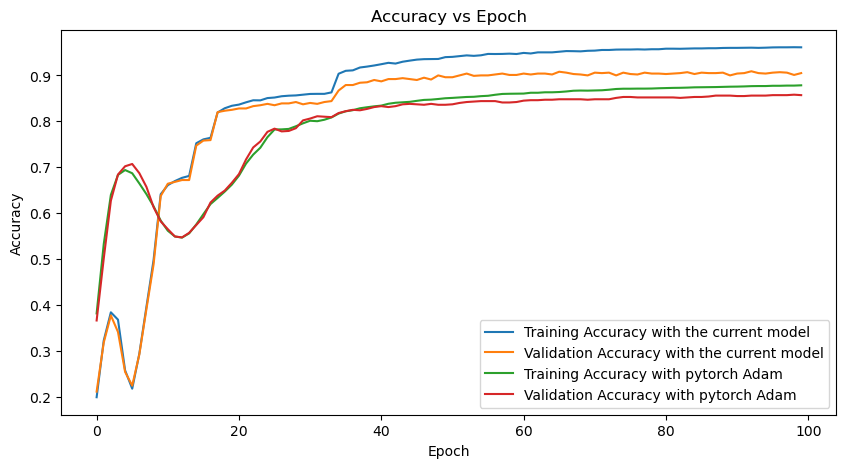

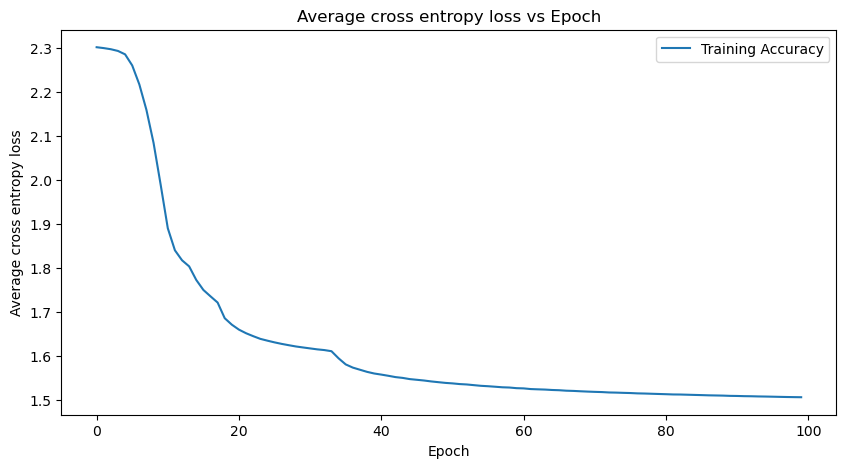

In [32]:
 trained_model = Train_Network(100,0.001,train_dataloader,val_dataloader,train_dataloader_1,val_dataloader_1,0)

Epoch 0, accuracy: 0.6924
Epoch 10, accuracy: 0.1886
Epoch 20, accuracy: 0.1724
Epoch 30, accuracy: 0.11
Epoch 40, accuracy: 0.11
Epoch 50, accuracy: 0.11
Epoch 60, accuracy: 0.11
Epoch 70, accuracy: 0.11
Epoch 80, accuracy: 0.11
Epoch 90, accuracy: 0.11


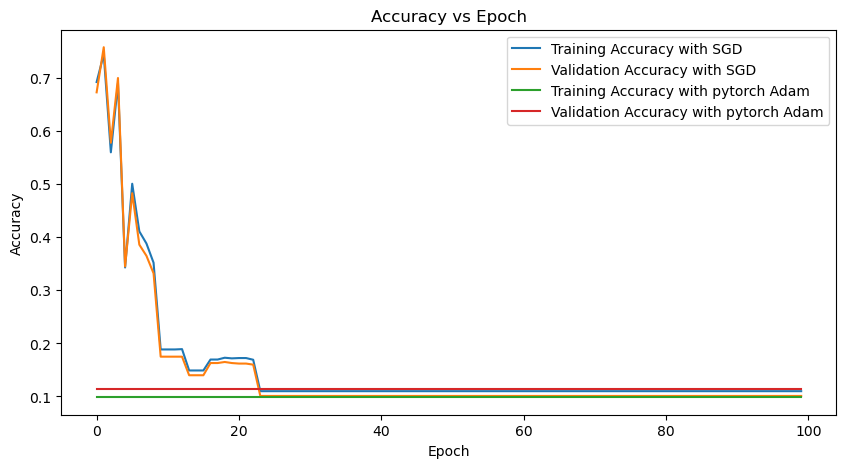

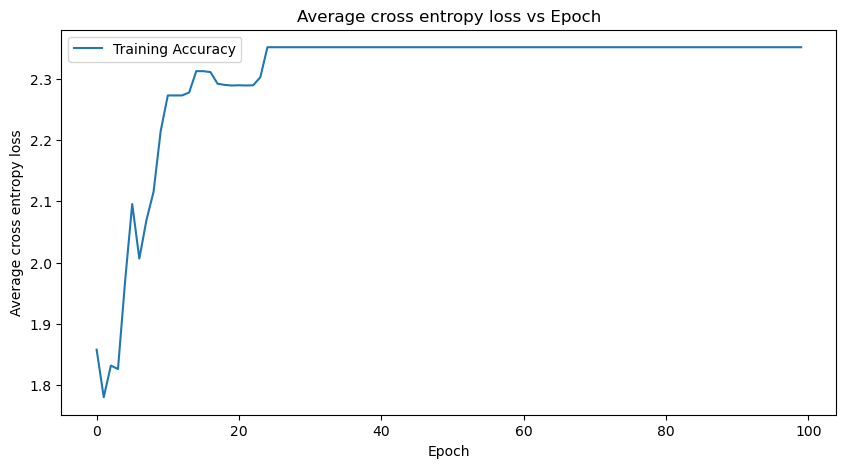

In [163]:
## with learning rate = 0.1
trained_model_2 = Train_Network(100,0.1,train_dataloader,val_dataloader,train_dataloader_1,val_dataloader_1,0)

### Model with momentum optimizer

Epoch 0, accuracy: 0.6422
Epoch 5, accuracy: 0.9356
Epoch 10, accuracy: 0.9574
Epoch 15, accuracy: 0.9686
Epoch 20, accuracy: 0.9774
Epoch 25, accuracy: 0.9786
Epoch 30, accuracy: 0.9794
Epoch 35, accuracy: 0.98
Epoch 40, accuracy: 0.9802
Epoch 45, accuracy: 0.9804
Epoch 50, accuracy: 0.9802
Epoch 55, accuracy: 0.981
Epoch 60, accuracy: 0.981


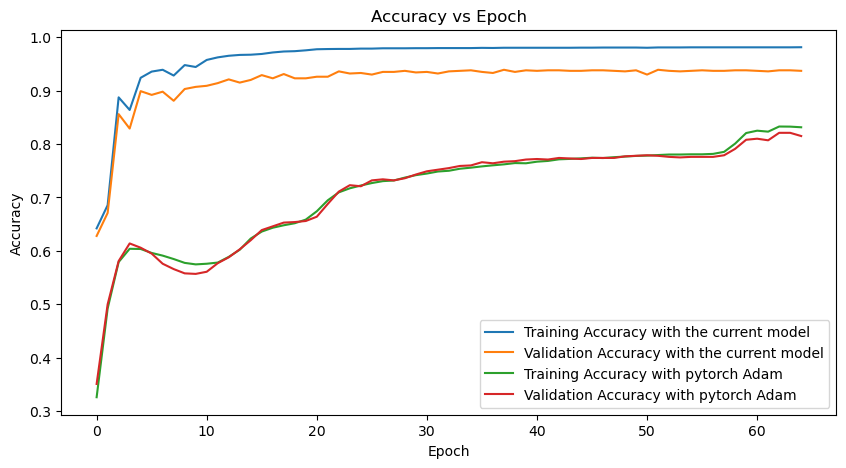

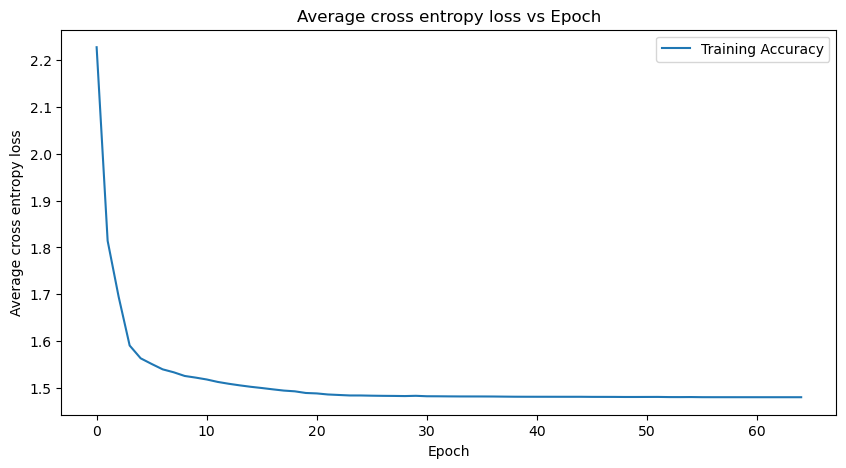

In [31]:
 trained_model_momentum = Train_Network(65,0.001,train_dataloader,val_dataloader,train_dataloader_1,val_dataloader_1,1)

### Model with Nestorov accelerated gradient

Epoch 0, accuracy: 0.6478
Epoch 5, accuracy: 0.8706
Epoch 10, accuracy: 0.882
Epoch 15, accuracy: 0.888
Epoch 20, accuracy: 0.8918
Epoch 25, accuracy: 0.8946
Epoch 30, accuracy: 0.9616
Epoch 35, accuracy: 0.9788
Epoch 40, accuracy: 0.9814
Epoch 45, accuracy: 0.9826
Epoch 50, accuracy: 0.9834
Epoch 55, accuracy: 0.9836
Epoch 60, accuracy: 0.9836


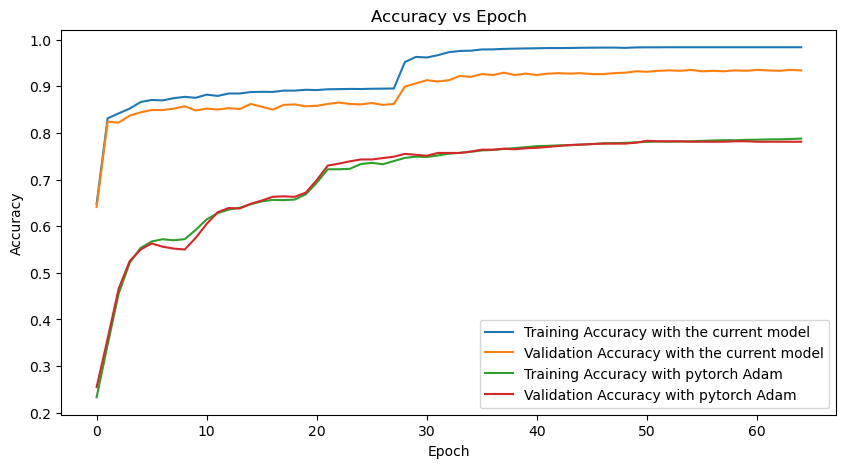

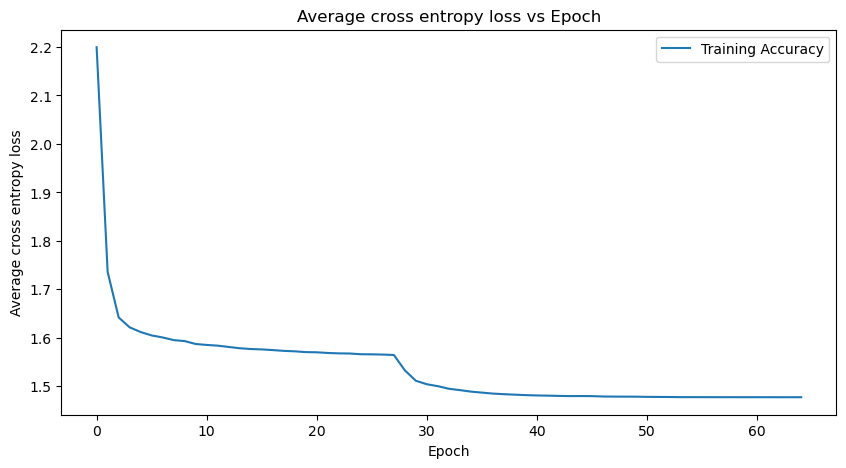

In [33]:
 trained_model_NAG = Train_Network(65,0.001,train_dataloader,val_dataloader,train_dataloader_1,val_dataloader_1,2)

### Model with AdaGrad

Epoch 0, accuracy: 0.6704
Epoch 5, accuracy: 0.8278
Epoch 10, accuracy: 0.8428
Epoch 15, accuracy: 0.85
Epoch 20, accuracy: 0.8532
Epoch 25, accuracy: 0.8562
Epoch 30, accuracy: 0.8574
Epoch 35, accuracy: 0.8586
Epoch 40, accuracy: 0.8612
Epoch 45, accuracy: 0.8626
Epoch 50, accuracy: 0.864
Epoch 55, accuracy: 0.8656
Epoch 60, accuracy: 0.8662
Epoch 65, accuracy: 0.867
Epoch 70, accuracy: 0.8668
Epoch 75, accuracy: 0.8674
Epoch 80, accuracy: 0.868
Epoch 85, accuracy: 0.8688
Epoch 90, accuracy: 0.8694
Epoch 95, accuracy: 0.8706


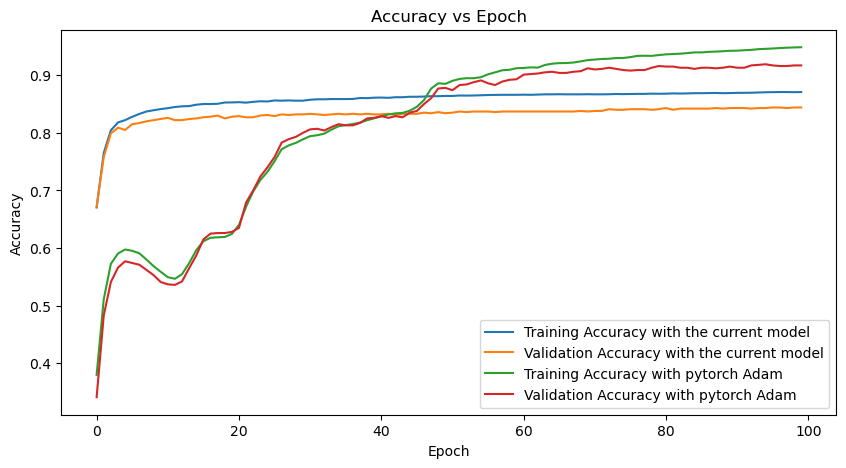

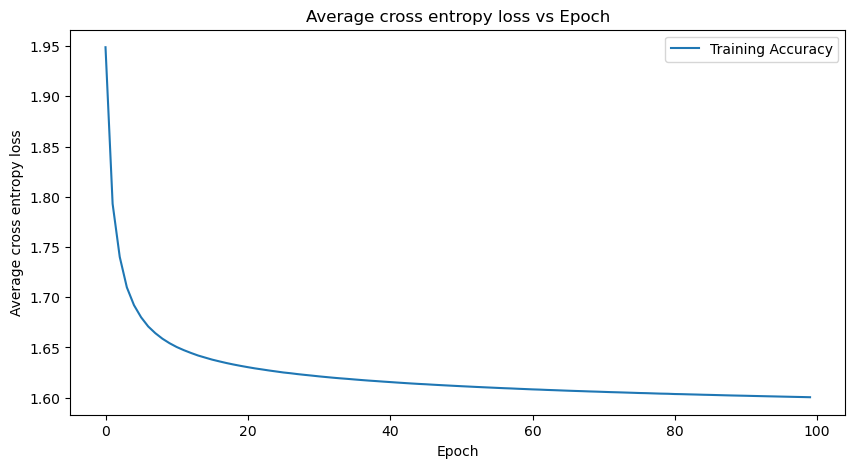

In [47]:
trained_model_AdaGrad = Train_Network(100,0.001,train_dataloader,val_dataloader,train_dataloader_1,val_dataloader_1,3)

### Model with RMSProp

Epoch 0, accuracy: 0.89
Epoch 5, accuracy: 0.947
Epoch 10, accuracy: 0.9694
Epoch 15, accuracy: 0.9778
Epoch 20, accuracy: 0.9794
Epoch 25, accuracy: 0.985
Epoch 30, accuracy: 0.984
Epoch 35, accuracy: 0.9858
Epoch 40, accuracy: 0.986
Epoch 45, accuracy: 0.9868
Epoch 50, accuracy: 0.987
Epoch 55, accuracy: 0.987
Epoch 60, accuracy: 0.9874


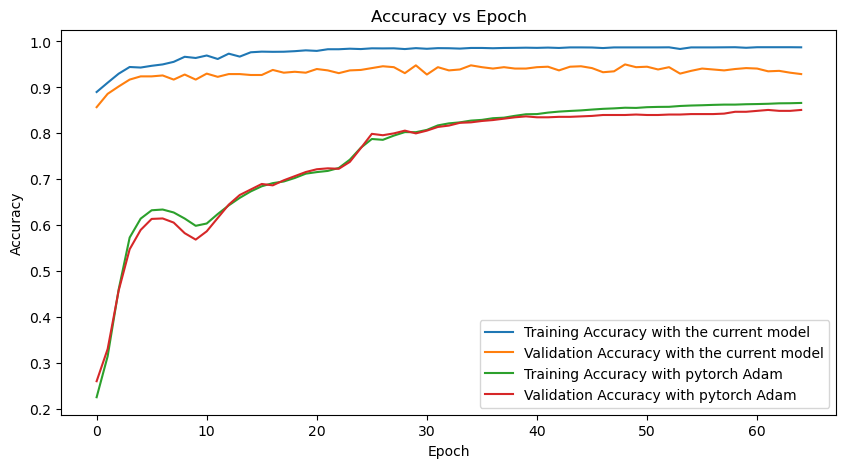

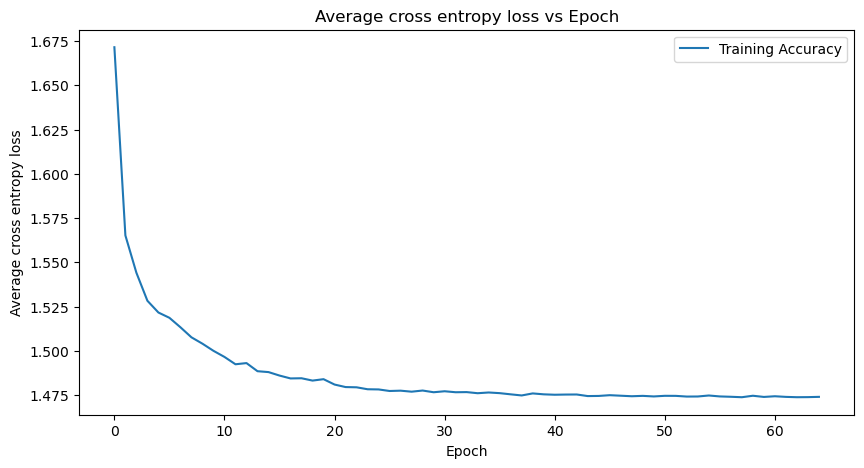

In [23]:
trained_model_RMSProp = Train_Network(65,0.001,train_dataloader,val_dataloader,train_dataloader_1,val_dataloader_1,4)

### Model with ADAM

Epoch 0, accuracy: 0.8656
Epoch 5, accuracy: 0.9242
Epoch 10, accuracy: 0.9554
Epoch 15, accuracy: 0.9528
Epoch 20, accuracy: 0.9562
Epoch 25, accuracy: 0.9458
Epoch 30, accuracy: 0.9582
Epoch 35, accuracy: 0.9404
Epoch 40, accuracy: 0.9658
Epoch 45, accuracy: 0.9578
Epoch 50, accuracy: 0.9592
Epoch 55, accuracy: 0.9744
Epoch 60, accuracy: 0.9604


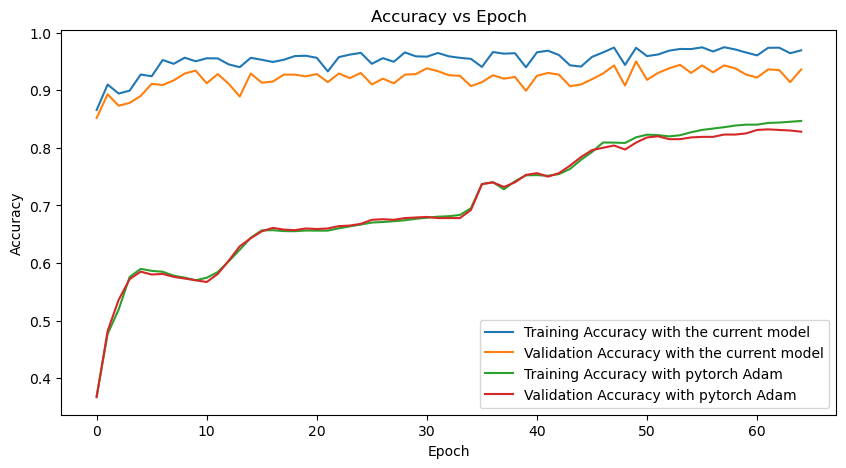

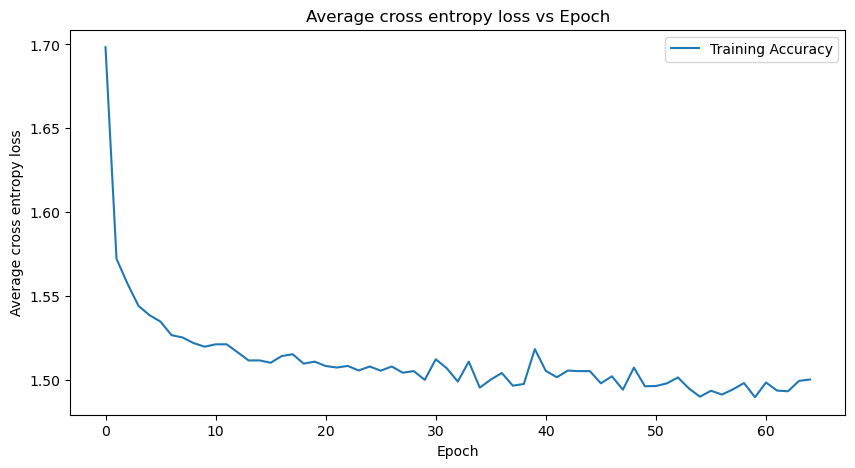

In [18]:
trained_model_ADAM = Train_Network(65,0.001,train_dataloader,val_dataloader,train_dataloader_1,val_dataloader_1,5)

### Model with ADAM (Bias correction)

Epoch 0, accuracy: 0.8998
Epoch 5, accuracy: 0.969
Epoch 10, accuracy: 0.982
Epoch 15, accuracy: 0.9834
Epoch 20, accuracy: 0.9834
Epoch 25, accuracy: 0.9882
Epoch 30, accuracy: 0.9888
Epoch 35, accuracy: 0.9882
Epoch 40, accuracy: 0.99
Epoch 45, accuracy: 0.9894
Epoch 50, accuracy: 0.9898
Epoch 55, accuracy: 0.9906
Epoch 60, accuracy: 0.9894


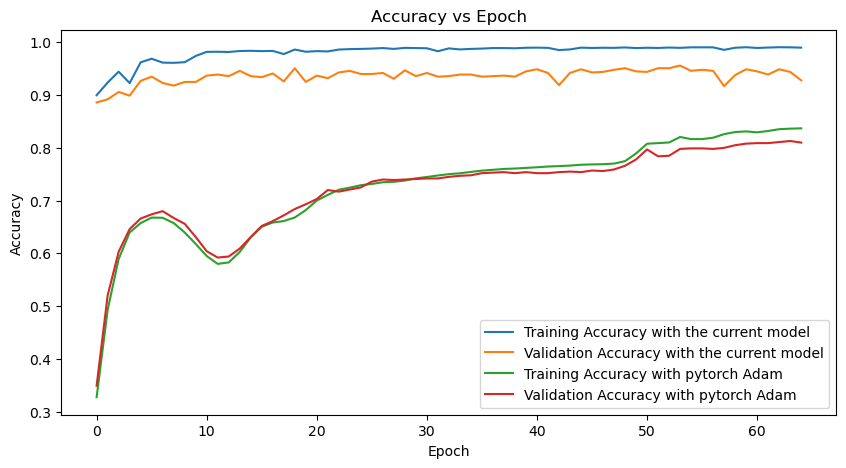

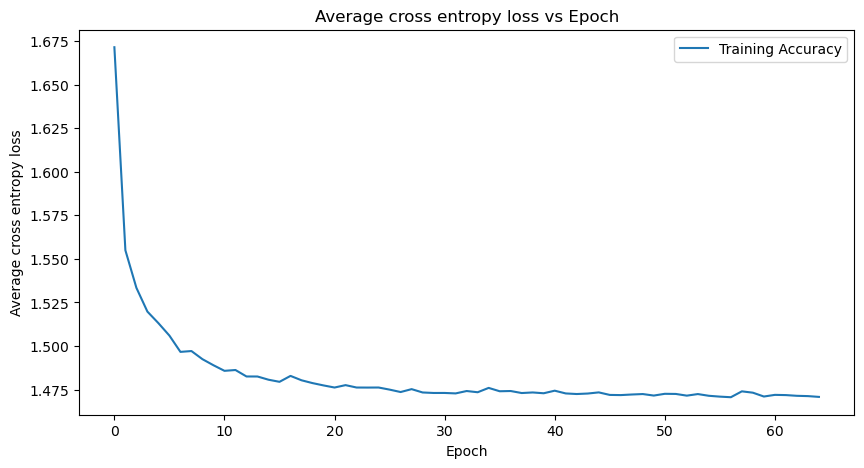

In [19]:
trained_model_ADAM_with_bias_correction = Train_Network(65,0.001,train_dataloader,val_dataloader,train_dataloader_1,val_dataloader_1,6)